## ***Natural Languagem Processing*** to predict if a headline from a news website contains sarcasm.

The task at hand involves predicting whether a given headline is **sarcastic** or not. This **binary classification problem** requires training a model to distinguish between genuinely factual statements and those that carry a sarcastic or ironic undertone. By analyzing a dataset of headlines labeled as sarcastic or non-sarcastic, the model can learn **patterns** in **language usage**, **word choice**, and **structure** that are often indicative of sarcasm. Successfully addressing this task will improve the accuracy of sentiment analysis models and enhance user experiences by helping systems better understand and process the nuances of **human language**.

In [381]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, re, numpy as np, scipy.stats
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [382]:
sarcasm_df = pd.read_csv('sarcasm.csv')

sarcasm_df['headline'] = sarcasm_df['headline'].apply(lambda x: x.lower())

sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Verifying **possible predictive variables**.

* In order to check whether the website **hostname** can be used as a **predictive** variable, the website host name is extracted and the proportion of **sarcastic** headlines for each *alias* is observed.

In [383]:
pattern = r"^https://([^/]+)/"

sarcasm_df['article_host'] = sarcasm_df['article_link'].apply(lambda row: re.search(pattern, row)[1]).drop(columns=['article_link'])

sarcasm_df = sarcasm_df[['article_host', 'headline', 'is_sarcastic']]

sarcasm_df.tail(n=10)

,article_host,headline,is_sarcastic
26699,www.huffingtonpost.com,"what you should buy your 'basic' friend, accor...",0
26700,www.huffingtonpost.com,what's in your mailbox? tips on what to do whe...,0
26701,www.huffingtonpost.com,paul ryan is more of a con man than ever,0
26702,politics.theonion.com,pentagon to withhold budget figures out of res...,1
26703,www.theonion.com,pope francis wearing sweater vestments he got ...,1
26704,www.huffingtonpost.com,american politics in moral free-fall,0
26705,www.huffingtonpost.com,america's best 20 hikes,0
26706,www.huffingtonpost.com,reparations and obama,0
26707,www.huffingtonpost.com,israeli ban targeting boycott supporters raise...,0
26708,www.huffingtonpost.com,gourmet gifts for the foodie 2014,0


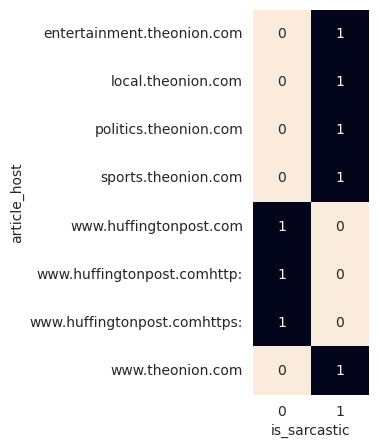

In [393]:
pivot = sarcasm_df.groupby(['article_host', 'is_sarcastic']).size().unstack(fill_value=0)
pivot = pivot.apply(lambda x: x / x.sum(), axis=1)

sns.set_palette("muted")
sns.set_style("darkgrid")
fig = plt.figure(figsize=(1.5, 5))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='rocket_r', cbar=False)

plt.show()

* From the sarcastic headlines proportions, it is clear to see that a especific website hostname is related to a unique class of **is_sarcastic** target variable, therefore it **cannot be used as a predictive variable** on this *natural language processing* task in order to extract from a non-deterministic variables a model to understand a headlines's pattern from the websites.

### Dataset balance **analysis**.

* At first, to check the target attribute balance in the class, the proportion between the classes is ploted with horizanl bars.

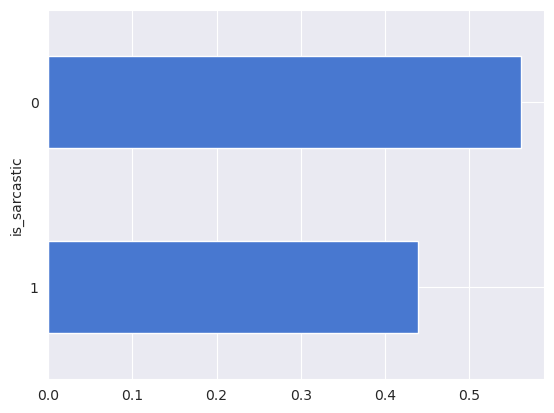

is_sarcastic
0    0.561047
1    0.438953
Name: proportion, dtype: float64

In [385]:
target_att_values = sarcasm_df['is_sarcastic'].value_counts(normalize=True)

target_att_values.sort_values().plot(kind='barh')
plt.show()

target_att_values

* According to the graph, it is clear to see that the classes are **disbalanced**, which implies a different way to deal with the database on the data analysis, model **training** and the model **evaluation** steps further ahead in this machine learning task.

### ***Tokenizing*** and checking the token count **distribution** between classes.

* At this step, it is used the tokenize function along with the steeming method to extract the words's radicals and remove the stopwords with `nltk`.

In [386]:
english_stopwords, stemmer = set(stopwords.words('english')), RSLPStemmer()

def extract_tokens(headline):
    return [stemmer.stem((word)) for word in word_tokenize(headline) if word not in english_stopwords]

sarcasm_df['tokens'] = sarcasm_df['headline'].apply(extract_tokens)

* After, in order to visualize if the number of **tokens** in a headline have some correlation with the sarcasm presence, it is made a **KDEplot** to check the attribute's distribution.

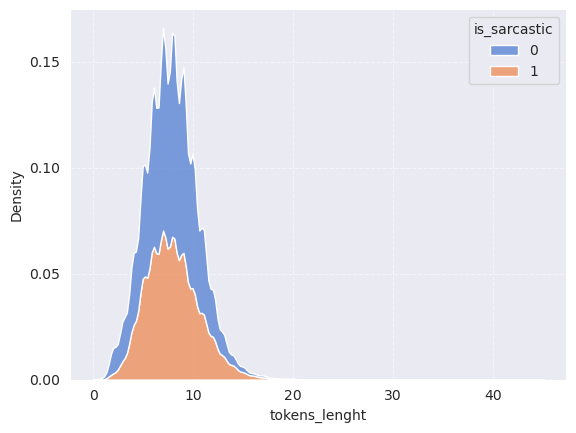

In [387]:
sarcasm_df['tokens_lenght'] = sarcasm_df['tokens'].apply(lambda x: len(x))

sns.kdeplot(data=sarcasm_df, x='tokens_lenght', hue="is_sarcastic", multiple='stack', alpha=0.7)
plt.grid(linestyle='--', alpha=0.5)
plt.yticks(np.arange(0, 0.2, step=0.05))
sns.despine()

plt.show()

In [388]:
tokens_lenght_sarcasm_splited = sarcasm_df.groupby('is_sarcastic')['tokens_lenght']

tokens_lenght_sarcasm_splited.describe()

,count,mean,std,min,25%,50%,75%,max
is_sarcastic,,,,,,,,
0,14985.0,7.733734,2.597891,1.0,6.0,8.0,9.0,24.0
1,11724.0,7.944899,2.722053,2.0,6.0,8.0,10.0,44.0


In [389]:
print(f'Skewness: \n{tokens_lenght_sarcasm_splited.skew()}', end='\n\n')

print(f'Kurtosis: \n{tokens_lenght_sarcasm_splited.apply(lambda x: scipy.stats.kurtosis(x))}')

Skewness: 
is_sarcastic
0    0.271960
1    1.016602
Name: tokens_lenght, dtype: float64

Kurtosis: 
is_sarcastic
0    0.708344
1    5.958531
Name: tokens_lenght, dtype: float64


In [390]:
tokens_lenght_corr = sarcasm_df['is_sarcastic'].corr(sarcasm_df['tokens_lenght'], method='spearman')

print(f'The spearman correlation coeficient is: {tokens_lenght_corr:.4f}')

The spearman correlation coeficient is: 0.0197


* According to the image, it is clear to see that sarcastic headlines have, in general, a bigger **tonkens_lenght** amplitude, which means that the obervations are more sparsely distributed in the space and the non-sarcastic objects have a more concentrated number of tokens. 

* Based on the **descriptive statistics** measures, it is possible to observe the higher attribute's **amplitude** on **sarcastic** headlines according to the minimum, maximum values and the skewness, that shows an **assymetry** to the left duo it's positive value. In addition to that, the **kurtosis** shows a flatter curve on sarcastic texts, closer to a normal distribution.

* However, the ***Spearman*** correlation coeficient, method used to soften the high attribute's amplitude effect to the coeficient, represents a **low correlation mathematically**.

* Threfore, it is possibly awaited that the **tokens_lenght** attribute might have a certain statistical relevance for the model to learn, hypothesis that will be infered at the learning step.

### Verifying words's **grammatical classes** and comparing between the target classes.

* At this moment is desired to extract the words's radicals grammatical classes and compare the classes proportion between non-sarcastic and sarcastic headlines. In order to do this, it is use the `pos_tag` method from `nltk` library to classify the words.

In [391]:
sarcasm_df['gramatical_classes'] = sarcasm_df['tokens'].apply(nltk.pos_tag)

sarcasm_df['gramatical_classes'].head()

0    [(form, NN), (versac, NN), (stor, NN), (clerk,...
1    [('roseann, POS), (', ''), (reviv, JJ), (catch...
2    [(mom, NN), (starting, VBG), (fe, JJ), (son, N...
3    [(boehn, NN), (want, VBP), (wif, NN), (listen,...
4    [(j.k., NN), (rowling, VBG), (wish, JJ), (snap...
Name: gramatical_classes, dtype: object

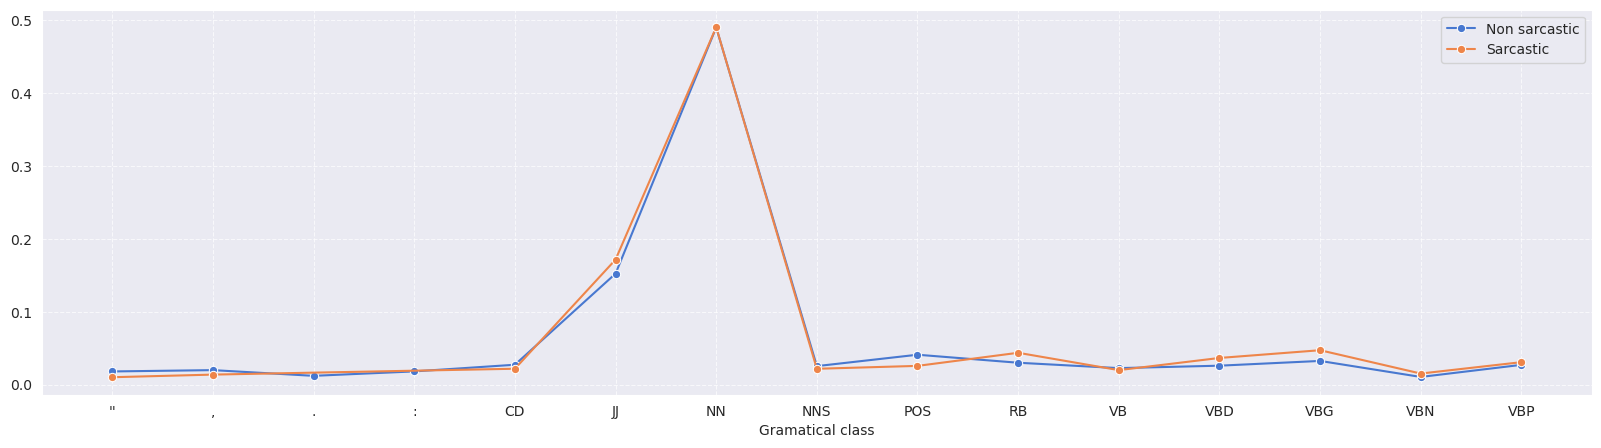

In [392]:
words_classes = sarcasm_df.explode('gramatical_classes')
words_classes[['word_stem', 'class']] = pd.DataFrame(words_classes['gramatical_classes'].tolist(), index=words_classes.index)

groups = words_classes.drop(columns=['gramatical_classes']).groupby('is_sarcastic')

plt.figure(figsize=(20, 5))

for target_att, variables in groups:
    classes_count = variables['class'].value_counts(normalize=True).sort_index()
    
    proportion_df = pd.DataFrame({'class': classes_count.index, 'proportion': classes_count.values})

    proportion_df = proportion_df[proportion_df['proportion'] >= 0.01]

    sns.lineplot(data=proportion_df, x='class', y='proportion', label='Non sarcastic' if target_att == 0 else 'Sarcastic', marker='o')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Gramatical class')
plt.ylabel('')
plt.legend()
plt.show()

* Based on the graph, it is possible to infer that the words distribution is **considerably similar** between non-sarcastic and sarcastic headlines, mainly on the most frequent class, the **nouns**, with some little differences on the less frequent classes.

* Therefore, despite the very similar distribution, there is a probability to the grammatical classes count show some **statistical relevance**.